***
    
Demo JAX for PINN (Physics-Informed Neural Network)
    
***

    Version: 2023-02-24
    
    Author : Nicholas Sung Wei Yong, Wong Jian Cheng, Ooi Chin Chun, Abhishek Gupta

    Contain:
    
    1. PINN for solving Non-linear Burgers equation
    
    2. Optimize PINN using Stochastic gradient descent on the JAX framework
       -  as described in Nicholas Sung Wei Yong, Jian Cheng Wong, Pao-Hsiung Chiu, Abhishek Gupta, Chinchun Ooi, Yew-Soon Ong
       "Neuroevolution Surpasses Stochastic Gradient Descent for Physics-Informed Neural Networks" arXiv preprint arXiv:2212.07624 (2022).

Import Libraries

In [1]:
import jax
import optax
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from typing import Any, Callable, Sequence, Optional
from jax import lax, random, numpy as jnp
import flax
from flax.core import freeze, unfreeze
from flax import linen as nn
from jax import random, grad, vmap, hessian, jacfwd, jit
from jax.config import config

# choose GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

Problem

In [2]:
def f_ic(x):
    return jnp.exp(-(k*x)**2)

PINNs Network

In [3]:
node = 6
class PINNs(nn.Module):
  """PINNs"""
  def setup(self):
    self.layers = [nn.Dense(node, kernel_init = jax.nn.initializers.glorot_uniform()),
                   nn.tanh,
                   nn.Dense(node, kernel_init = jax.nn.initializers.glorot_uniform()),
                   nn.tanh,
                   nn.Dense(node, kernel_init = jax.nn.initializers.glorot_uniform()),
                   nn.tanh,
                   nn.Dense(1, kernel_init = jax.nn.initializers.glorot_uniform(), use_bias=False)]


  @nn.compact
  def __call__(self, inputs):
      # split the two variables, probably just by slicing
      x, t = inputs[:,0:1], inputs[:,1:2]
      
      def get_u(x, t):
        u = jnp.hstack([x, t])
        for i, lyr in enumerate(self.layers):
          u = lyr(u)
        return u

      u = get_u(x, t)

      # obtain u_t
      def get_u_t(get_u, x, t):
        u_t = jacfwd(get_u, 1)(x, t)
        return u_t
      u_t_vmap = vmap(get_u_t, in_axes=(None, 0, 0))
      u_t = u_t_vmap(get_u, x, t).reshape(-1,1) 
      #obtain u_x
      def get_u_x(get_u, x, t):
        u_x = jacfwd(get_u)(x, t)
        return u_x
      u_x_vmap = vmap(get_u_x, in_axes=(None, 0, 0))
      u_x = u_x_vmap(get_u, x, t).reshape(-1,1)  
      #obtain u_xx    
      def get_u_xx(get_u, x, t):
        u_xx = hessian(get_u)(x,t)
        return u_xx
      u_xx_vmap = vmap(get_u_xx, in_axes=(None, 0, 0))
      u_xx = u_xx_vmap(get_u, x, t).reshape(-1,1)

      action = jnp.hstack([u,u_x, u_xx, u_t])   
      return action
model = PINNs()

In [4]:
# choose seed
seed = 0
key1, key2 = random.split(random.PRNGKey(seed))
a = random.normal(key1, [1,2]) # Dummy input
params = model.init(key2, a) # Initialization call

In [5]:
from evojax.util import get_params_format_fn
num_params, format_params_fn = get_params_format_fn(params)
num_params

108

Hyper parameters and data 

In [6]:
vis = 0.001

# initial condition
k = 2

# spatial domain
x_l, x_u = -2.0, 2.0

# time domain: 0 - t_T
t_T = 2.0

sim = pd.read_csv('nonlinear.csv')
sim['x'], sim['t'] = sim['x'], sim['t']
x_train = jnp.vstack([sim.x.values, sim.t.values]).T
y_train = sim[['u']].values
x = x_train[:,0:1].reshape(-1,1)
t = x_train[:,1:2].reshape(-1,1)

_train1 = np.argwhere(t != 0.0)[:, 0]
x_train1 = x[_train1].reshape(-1,1)
t_train1 = t[_train1].reshape(-1,1)
y_train1 = y_train[_train1].reshape(-1,1)

_train2 = np.argwhere(t == 0.0)[:, 0]
x_train2 = x[_train2].reshape(-1,1)
t_train2 = t[_train2].reshape(-1,1)
y_train2 = y_train[_train2].reshape(-1,1)

data_all = jnp.hstack([x,t])
label_all = y_train
data_pde = jnp.hstack([x_train1, t_train1])
label_pde = y_train1
data_bc = jnp.hstack([x_train2, t_train2])
label_bc = y_train2
label_pde.shape[0]

25800

Loss Function

In [7]:
# loss function parameter
lmbda = 1 #500

In [8]:
def loss(params, input):
    x = input[:,0:1].reshape(-1,1)
    t = input[:,1:2].reshape(-1,1)
    prediction = model.apply(format_params_fn(params), jnp.hstack([x, t]))
    u, u_x, u_xx, u_t = prediction[:,0:1], prediction[:,1:2], prediction[:,2:3], prediction[:,3:4]
    # ground truth

    t_u = f_ic(x) 
    _ic = jnp.where((jnp.equal(t, 0)), 1, 0)
    # _bc = ( jnp.equal(x, x_l) | jnp.equal(x, x_u) )
    ic_mse = jnp.sum(jnp.square((t_u-u)*_ic))/jnp.sum(_ic)
    # PDE (physics laws) 
    pde = u_t + u*u_x - vis*u_xx


    # exclude BC points
    _pde = jnp.where((jnp.equal(t, 0)), 0, 1)
    pde = pde*_pde
    pde_mse = jnp.sum(jnp.square(pde))/jnp.sum(_pde)
    pde_mse = pde_mse 
    loss = pde_mse + ic_mse
    return loss
  
#loss_grad = jax.jit(jax.grad(loss))
loss_grad = jax.jit(jax.value_and_grad(loss))    

Weights Update

In [9]:
def update(params, opt_state, batch_data):
    loss_value, grad = loss_grad(params, batch_data)
    updates, opt_state = optimizer.update(grad, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value

update = jit(update)

Initialization

In [10]:
# initial params
params = model.init(key2, a) # Initialization call

# flatten initial params
params = jax.flatten_util.ravel_pytree(params)[0]

Optimizer

In [11]:
alpha = 0.1
#optimizer = optax.adam(learning_rate=alpha) # Choose the method
optimizer = optax.sgd(learning_rate=alpha) # Choose the method
opt_state = optimizer.init(params)

Minibatching

In [12]:
BS_pde = 10
BS_bc = 5


def minibatch(train_iters):
    _batch_pde = jax.random.choice(random.PRNGKey(train_iters), label_pde.shape[0], (BS_pde,))
    _batch_bc = jax.random.choice(random.PRNGKey(train_iters), label_bc.shape[0], (BS_bc,))
    batch_data = jnp.vstack([data_pde[_batch_pde], data_bc[_batch_bc]])
    return batch_data

minibatch = jit(minibatch)

Training 

In [13]:
max_iters = 500000
loss_ls = []
t_training = []
runtime = 0
train_iters = 0

# fullbatchloss = np.inf
# fullbatchloss_ls = []

while (train_iters < max_iters) and (runtime < 180):
#     loss_value, _ = loss_grad(params, data_all)
#     print(loss_value)
#     fullbatchloss = min(fullbatchloss, loss_value)
#     fullbatchloss_ls.append(fullbatchloss)
    start = time.time()
    # stochastic update
    batch_data = minibatch(train_iters)
    params, opt_state, loss_value = update(params, opt_state, batch_data)
    end = time.time()
    t_training.append(end-start)
    loss_ls.append(loss_value)
    runtime += (end-start)
    train_iters += 1    
    # append weights
    show_iters = [1000, 5000, 10000, 50000, 100000]
    if (train_iters in show_iters):
        print('Loss step {}: '.format(train_iters), loss_value)
              
# final train_iters
train_iters

Loss step 1000:  0.01132706
Loss step 5000:  0.0070828814
Loss step 10000:  0.010087021
Loss step 50000:  0.0017059542
Loss step 100000:  0.0060164104


410667

In [14]:
# process results
import numpy as np
import pandas as pd

In [15]:
training_ls = np.cumsum(t_training)
training_ls

array([  4.12286091,   4.12342334,   4.12381339, ..., 179.99947429,
       179.9998095 , 180.0001893 ])

In [16]:
loss_ls[-1]

DeviceArray(0.27615523, dtype=float32)

In [17]:
min(loss_ls)

DeviceArray(2.028087e-12, dtype=float32)

In [18]:
# fullbatchloss_ls

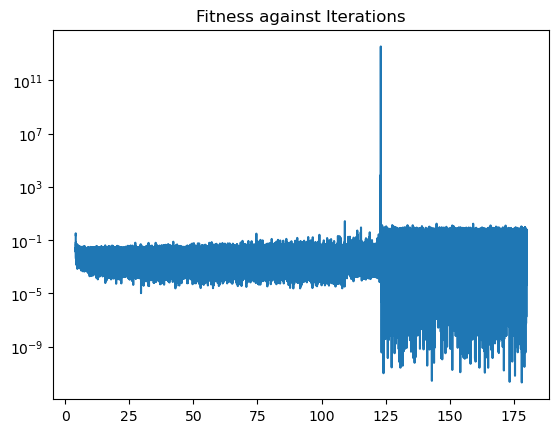

In [19]:
plt.plot(training_ls, loss_ls); plt.yscale('log');
plt.title('Fitness against Iterations')
plt.show()

#### Visualize results

DeviceArray(0.49849704, dtype=float32)

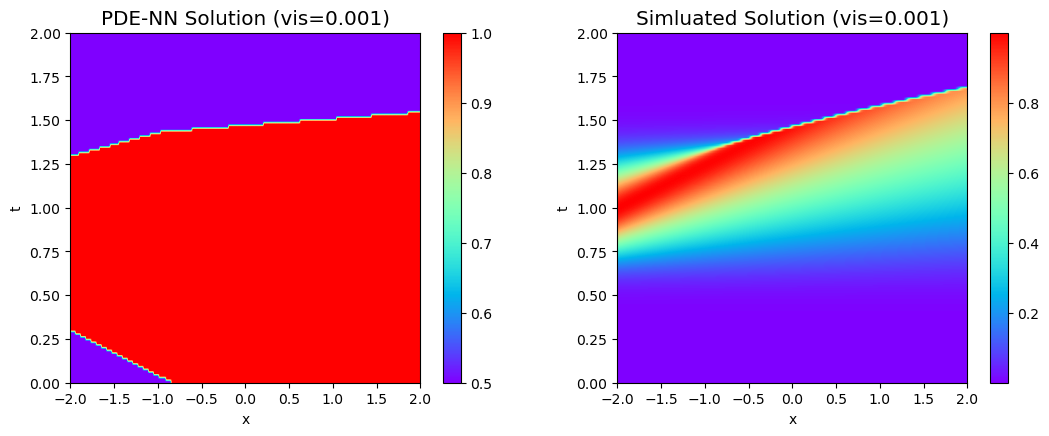

In [20]:
# plot final
hello = PINNs()
prediction = hello.apply(format_params_fn(params), data_all)
u = prediction[:,0:1]
fig = plt.figure(figsize=(20, 10))
u_viz = (u.reshape(201, 129)).T 
ext = [x_l, x_u, 0 ,t_T]     # plot boundary 
ax1 = fig.add_subplot(2,3,1)
mesh =ax1.imshow(u_viz, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, aspect=2); 
plt.colorbar(mesh) 
plt.xlabel('x'); plt.ylabel('t'); 
plt.title('PDE-NN Solution (vis=%s)' %(vis), fontsize='x-large'); 


u_true = (label_all.reshape(201, 129)).T 
ext = [x_l, x_u, 0 ,t_T]     # plot boundary 
ax2 = fig.add_subplot(2,3,2)
mesh2 = ax2.imshow(u_true, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, aspect=2); 
plt.colorbar(mesh2); 
plt.xlabel('x'); plt.ylabel('t'); 
plt.title('Simluated Solution (vis=%s)' %(vis), fontsize='x-large'); 
# plt.savefig('solutionplot2/(params_size=%s_popn=%s_init_std=%s).png' %(params_size, popn, init_std))

jnp.mean(jnp.square(label_all - u))